#Resolución SDO

# Sistema de Lorenz: Modelo caótico de dinámica atmosférica 🔄🌀

El sistema de **Lorenz** es un conjunto de ecuaciones diferenciales ordinarias no lineales que modela la convección térmica en la atmósfera. Introducido por Edward Lorenz en 1963 como una simplificación del modelo de circulación atmosférica.

Este sistema está formado por tres ecuaciones acopladas:
$$
\begin{cases}
\displaystyle\frac{dx}{dt} &= \sigma (y - x), \\
\displaystyle\frac{dy}{dt} &= x(\rho - z) - y, \\
\displaystyle\frac{dz}{dt} &= xy - \beta z,\\
\end{cases}
$$

donde:
- $ x $ representa la velocidad de convección,
- $ y$ la diferencia de temperatura entre las corrientes ascendentes y descendentes,
- $ z $ la desviación de la temperatura vertical,
- y los parámetros $ \sigma $, $ \rho $, y $ \beta $ son constantes físicas relacionadas con la viscosidad del fluido y la diferencia de temperatura.

Las condiciones iniciales son:
$$x(0)=1.0,\quad y(0)=1.0,\quad z(0)=1.0.$$

El sistema presenta un comportamiento **altamente sensible a las condiciones iniciales**, característica del caos determinista. Su solución en el espacio tridimensional forma una figura famosa conocida como el **atractor de Lorenz**, con forma de mariposa.

<img src="https://raw.githubusercontent.com/leflores-fisi/lorenz-attractor/main/imgs/lorenz_butterfly.jpg" width=180 heigth=180>

Aproximamos la solución del sistema de Lorenz usando una **PINN (Physics-Informed Neural Network)**, que ilustra la capacidad para aprender la trayectoria del sistema en el tiempo e ilustra la potencia de este enfoque para resolver sistemas dinámicos no lineales.

A continuación, definimos el código utilizando *Pytorch*:

In [89]:
# Importar librerias
import numpy as np                 # Manejo de vectores y matrices (arrays)
import torch                       # Biblioteca principal para cálculo tensorial y redes neuronales
import torch.nn as nn              # Componentes para construir redes neuronales (capas, activaciones)
import torch.optim as optim        # Algoritmos de optimización para ajustar parámetros de la red
import torch.nn.init as init       # Métodos para inicializar pesos de redes neuronales
import torch.autograd as grad      # Cálculo automático de derivadas (gradientes)
import matplotlib.pyplot as plt    # Herramientas para visualización gráfica de resultados
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
import time                        # Funciones para medir tiempos de ejecución
import math                        # Funciones matemáticas elementales (trigonometría, exponenciales, etc.)
import torch.nn.functional as F    # Funciones matemáticas sin parámetros para redes (activaciones, pérdidas)
from scipy.integrate import solve_ivp

###Aproximacion solve_ivp

In [90]:
# Parámetros Lorenz
sigma, rho, beta = 10.0, 28.0, 8/3

# Definición del sistema Lorenz para solve_ivp (t, state, ...)
def solve_lorenz(t, state, sigma, rho, beta):
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return [dx, dy, dz]

# Condiciones iniciales
initial_state = [1., 1., 1.]

# Intervalo de tiempo y puntos donde evaluar la solución
t_span = (0, 100)
t_eval = np.linspace(t_span[0], t_span[1], 3000)

In [91]:
# Resolver sistema con solve_ivp
sol = solve_ivp(solve_lorenz, t_span, initial_state, args=(sigma, rho, beta), t_eval=t_eval)

xs = sol.y[0]
ys = sol.y[1]
zs = sol.y[2]

#### Gráfica 2D

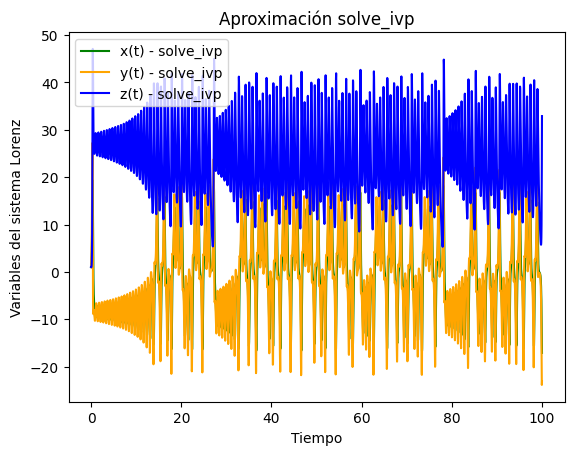

In [92]:
plt.figure()
plt.plot(sol.t, sol.y[0], color='green', label="x(t) - solve_ivp")
plt.plot(sol.t, sol.y[1], color='orange', label="y(t) - solve_ivp")
plt.plot(sol.t, sol.y[2], color='blue', label="z(t) - solve_ivp")

plt.legend()
plt.title(f'Aproximación solve_ivp')
plt.xlabel("Tiempo")
plt.ylabel("Variables del sistema Lorenz")
plt.show()

#### Gráfica 3D

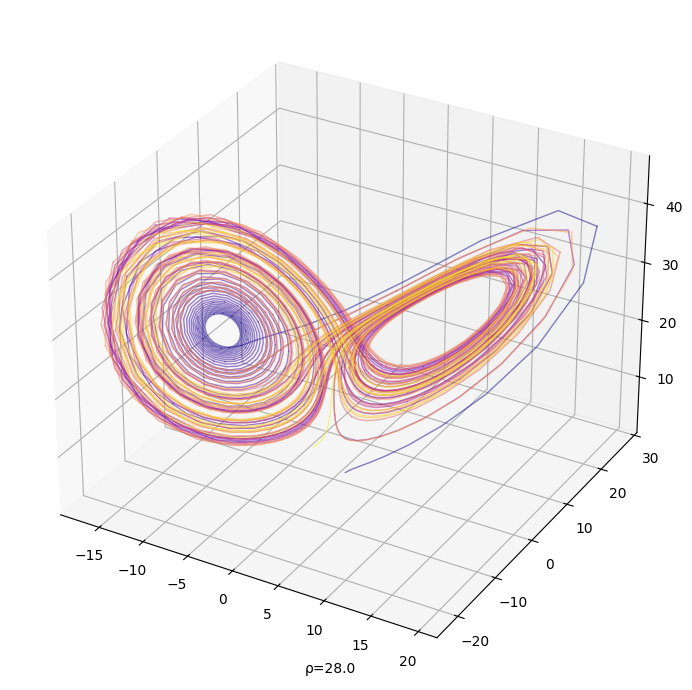

In [93]:
# Colormap para la gráfica
cmap = plt.cm.plasma

# Función para graficar el atractor coloreado
def lorenz_attractor(state0, parameters, ax=None, text_offset=0.01):
    sigma, rho, beta = parameters
    n = len(sol.t)
    xs = sol.y[0]
    ys = sol.y[1]
    zs = sol.y[2]

    if ax is None:
        ax = plt.figure(figsize=(7, 8)).add_subplot(projection='3d')

    s = 10
    for i in range(0, n - s, s):
        ax.plot(xs[i:i+s+1], ys[i:i+s+1], zs[i:i+s+1], color=cmap(i/n), alpha=0.5, lw=1)

    ax.text2D(0.44, text_offset, f"ρ={rho}", transform=ax.transAxes)
    ax.figure.tight_layout()
    return ax.figure

# Graficar atractor
lorenz_attractor(initial_state, (sigma, rho, beta)).show()

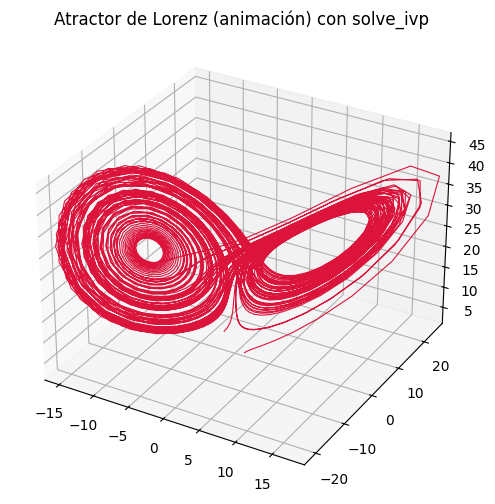

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [94]:
# Configuración del gráfico 3D para animación
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
line, = ax.plot([], [], [], lw=0.8, color='crimson')
ax.set_xlim((min(xs), max(xs)))
ax.set_ylim((min(ys), max(ys)))
ax.set_zlim((min(zs), max(zs)))
ax.set_title("Atractor de Lorenz (animación) con solve_ivp")

# Inicialización de la animación
def init():
    line.set_data([], [])
    line.set_3d_properties([])
    return line,

# Actualización del frame de la animación
def update(frame):
    line.set_data(xs[:frame], ys[:frame])
    line.set_3d_properties(zs[:frame])
    return line,

# Crear la animación
ani = FuncAnimation(fig, update, frames=range(0, len(t_eval), 10), init_func=init,
                    blit=False, interval=10, repeat=False)

# Guardar animación en MP4 (requiere ffmpeg instalado)
ani.save('sistemaLorenz.mp4', writer='ffmpeg', fps=20)

# Mostrar animación
plt.show()

# Descargar el video en Google Colab
from google.colab import files
files.download('sistemaLorenz.mp4')

###Aproximación PINN

In [95]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())

cpu


#### Definición red neuronal

In [96]:
# Definición de Red Neuronal de Propagación Adelante (Feedforward)

class PINN(nn.Module):                                           # Clase PINN es una subclase de nn.Module

    def __init__(self, input_size, hidden_size, output_size):    # Constructor que se ejecuta cuando se crea una instancia de la clase PINN
                                                                 # Este método inicializa las capas de la red neuronal
        super(PINN, self).__init__()                             # Llama al constructor de la clase base nn.Module


        # Capas de la red neuronal (3 capas lineales: nn.Linear)

        # Estas capas representan las conexiones ponderadas entre las neuronas de capas consecutivas.
        #  nn.Linear(input_size, hidden_size)
        #  input_size : es la cantidad de entradas (neuronas en la capa anterior)
        #  hidden_size: la cantidad de salidas (neuronas en la capa actual)
        # Capa lineal => Salida = Entradas × Pesos + Sesgo

        # Capa 1: Recibe input_size características como entrada y produce hidden_size características como salida
        self.fc1 = nn.Linear(input_size, hidden_size)

        # Capa 2: Recibe hidden_size características de la capa anterior y devuelve hidden_size características
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)

        # Capa 3: Recibe hidden_size características y devuelve output_size características (salida final de la red)
        self.fc6 = nn.Linear(hidden_size, output_size)

        # Inicialización de pesos:

        # 1) Random Initialization
        # Inicializar los pesos de las capas con valores aleatorios: distribución normal o uniforme
        #
        # nn.init.normal_(layer.weight, mean=0.0, std=0.01)       # Distribución normal
        # o
        # nn.init.uniform_(layer.weight, a=0, b=1)                # Distribución uniforme

        # 2) Xavier/Glorot Initialization
        # Técnica usada para redes neuronales con funciones de activación como la tangente hiperbólica (torch.tanh)
        # Esta inicialización: - ayuda a que la varianza de los valores de las activaciones permanezca constante entre capas
        #                      - mejora la estabilidad del entrenamiento

        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.xavier_normal_(self.fc4.weight)
        nn.init.xavier_normal_(self.fc5.weight)
        nn.init.xavier_normal_(self.fc6.weight)

        # Inicializacion de las bias
        nn.init.zeros_(self.fc1.bias.data)
        nn.init.zeros_(self.fc2.bias.data)
        nn.init.zeros_(self.fc3.bias.data)
        nn.init.zeros_(self.fc4.bias.data)
        nn.init.zeros_(self.fc5.bias.data)
        nn.init.zeros_(self.fc6.bias.data)
    # Propagación hacia adelante (forward):

    def forward(self, x):

       # Método forward: define cómo los datos pasan a través de la red
       # 1) Los datos de entrada x pasan por la capa 1 (fc1), y luego se les aplica la función de activación tangente hiperbólica (torch.tanh)
       # 2) Lo mismo ocurre con la capa 2 (fc2), aplicando nuevamente torch.tanh
       # 3) Finalmente, en la capa 3 (fc3), no se aplica ninguna función de activación, y los resultados se devuelven tal como están
       x = torch.tanh(self.fc1(x))
       x = torch.tanh(self.fc2(x))
       x = torch.tanh(self.fc3(x))
       x = torch.tanh(self.fc4(x))
       x = torch.tanh(self.fc5(x))
       x = self.fc6(x)                                             # No aplicamos función de activación en la última capa fc3

       return x

In [97]:
def calcul_derivadas(model, x):
    g = x.clone()
    g.requires_grad_(True)
    y_predec = model(g)
    r1 = y_predec[:, 0].view(-1, 1)  # x(t)
    r2 = y_predec[:, 1].view(-1, 1)  # y(t)
    r3 = y_predec[:, 2].view(-1, 1)  # z(t)   <-- NUEVO

    r1_t = torch.autograd.grad(r1, g, grad_outputs=torch.ones_like(r1), retain_graph=True, create_graph=True)[0]
    r2_t = torch.autograd.grad(r2, g, grad_outputs=torch.ones_like(r2), retain_graph=True, create_graph=True)[0]
    r3_t = torch.autograd.grad(r3, g, grad_outputs=torch.ones_like(r3), retain_graph=True, create_graph=True)[0]  # NUEVO

    return r1, r2, r3, r1_t, r2_t, r3_t   # MODIFICADO para incluir la tercera variable

def cond_inicial(model, x_initial):
    return model(x_initial * torch.ones(1, 1))

In [98]:
class PINNLoss(nn.Module):
    def __init__(self):
        super(PINNLoss, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, model, r1_t, r2_t, r3_t, r1, r2, r3, t0, y0):
        # Lorenz system parameters
        sigma, rho, beta = 10.0, 28.0, 8.0/3.0

        # Definimos el RHS de las ecuaciones de Lorenz:
        rhs1 = sigma * (r2 - r1)                # dx/dt = σ(y - x)
        rhs2 = r1 * (rho - r3) - r2             # dy/dt = x(ρ - z) - y
        rhs3 = r1 * r2 - beta * r3              # dz/dt = xy - βz

        loss_pde = self.mse_loss(r1_t, rhs1)
        loss_pde += self.mse_loss(r2_t, rhs2)
        loss_pde += self.mse_loss(r3_t, rhs3)

        y_0 = cond_inicial(model, t0)
        loss_initial_condition = self.mse_loss(y_0, y0)

        total_loss = loss_pde + loss_initial_condition
        return total_loss

In [99]:
y0 = [1.0, 1.0, 1.0]  # condición inicial clásica Lorenz
y0 = torch.tensor(y0, dtype=torch.float32).view(1, -1).to(device)
print(y0)

tensor([[1., 1., 1.]])


####Entrenamiento red neuronal

In [100]:
def train(model, optimizer, loss_fn, t0, y0, t_p, num_epochs, scheduler, print_freq=100):

    learning_rates = []  # Para guardar learning rates por época
    loss_history = []    # Para guardar pérdidas por época

    for epoca in range(num_epochs):
        model.train()

        # Calculamos las predicciones y derivadas para r1, r2, r3
        r1, r2, r3, r1_t, r2_t, r3_t = calcul_derivadas(model, t_p)

        # Calculamos la pérdida con la función loss_fn que debe ser compatible con Lorenz
        loss = loss_fn(model, r1_t, r2_t, r3_t, r1, r2, r3, t0, y0)

        # Backpropagation y actualización de pesos
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Actualizamos el scheduler
        scheduler.step()

        # Guardamos métricas
        loss_history.append(loss.item())
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)

        # Mostrar progreso cada print_freq épocas
        if (epoca + 1) % print_freq == 0:
            print(f'Epoch [{epoca+1}/{num_epochs}], Total Loss: {loss.item():.6f}')

    return loss_history, learning_rates

In [101]:
t0,tf = 0.0,40
t_p = torch.linspace(t0,tf,1500).view(-1,1).requires_grad_(True)
t_p = t_p.float().to(device)

#### Hiperparámetros de la red

In [102]:
# 1) Definición de los parámetros de la red

# model = PINN(input_size, hidden_size, output_size)

# Configuración de las dimensiones de la red neuronal
# Datos de entrada:
# - input_size
# - hidden_size
# - output_size

  # Numero de neuronas en cada capa
input_size = 1
hidden_size = 25
#hidden_size = 30        # Distinto número de neuronas en la capa oculta
#hidden_size = 200
output_size = 3

# 2) Instancia del modelo

model = PINN(input_size, hidden_size, output_size)
model.to(device)
# 3) Instancia del optimizador
  # - El optimizador que estamos usando es Adam, un optimizador muy popular que adapta el learning rate para cada parámetro de manera eficiente
  # - La función de pérdida que estamos utilizando es MSELoss, una función común para tareas de regresión

learning_rate = 0.01
# learning_rate = 0.01  # Ajustable
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

loss_fn = PINNLoss()

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.99) # learning rate

# 4) Entrenamiento

# Registramos el tiempo de inicio
start_time = time.time()

# -Numero de iteraciones:
num_epoch = 20000
# Experimentamos con diferente número de iteraciones
#num_epoch = 80000
#num_epoch = 40000
#num_epoch = 35000
#num_epoch = 48000
#num_epoch = 22000
#num_epoch =15000
#num_epoch = 10000
#num_epoch = 1000000
# num_epoch = 5000

# 4) Entrenamos el modelo utilizando la función de entrenamiento
# La función train que definimos anteriormente será responsable de hacer el proceso de propagación hacia adelante, cálculo de la pérdida, retropropagación y optimización.
loss_history, learning_rates = train(model, optimizer, loss_fn,t0,y0,t_p, num_epoch, scheduler)

# 5) Medición del tiempo de entrenamiento
# Registramos el tiempo de finalización
end_time = time.time()

# Calculamos el tiempo transcurrido
elapsed_time = end_time - start_time
print(f' ')
print(f'Tiempo de ejecución: {elapsed_time} segundos')

Epoch [100/20000], Total Loss: 0.734420
Epoch [200/20000], Total Loss: 0.587938
Epoch [300/20000], Total Loss: 0.547132
Epoch [400/20000], Total Loss: 0.525610
Epoch [500/20000], Total Loss: 0.510195
Epoch [600/20000], Total Loss: 0.498619
Epoch [700/20000], Total Loss: 0.489934
Epoch [800/20000], Total Loss: 0.483428
Epoch [900/20000], Total Loss: 0.478546
Epoch [1000/20000], Total Loss: 0.474877
Epoch [1100/20000], Total Loss: 0.472126
Epoch [1200/20000], Total Loss: 0.470061
Epoch [1300/20000], Total Loss: 0.468490
Epoch [1400/20000], Total Loss: 0.467269
Epoch [1500/20000], Total Loss: 0.466302
Epoch [1600/20000], Total Loss: 0.465524
Epoch [1700/20000], Total Loss: 0.464884
Epoch [1800/20000], Total Loss: 0.464346
Epoch [1900/20000], Total Loss: 0.463883
Epoch [2000/20000], Total Loss: 0.463474
Epoch [2100/20000], Total Loss: 0.463103
Epoch [2200/20000], Total Loss: 0.462756
Epoch [2300/20000], Total Loss: 0.462426
Epoch [2400/20000], Total Loss: 0.462103
Epoch [2500/20000], Total

In [103]:
t = torch.linspace(t0, tf, 200).view(-1,1).float().to(device)  # Asegura tipo float y dispositivo

y = model(t).detach()                                          # Predicciones sin tracking de gradientes

print(y)
print(y.shape)                                                 # Para verificar las dimensiones, debería ser [200, 3] para Lorenz

tensor([[ 9.9984e-01,  1.0000e+00,  9.9995e-01],
        [ 4.2202e-03, -7.2463e-03,  5.2119e-01],
        [-9.2927e-06,  3.0553e-03,  3.0402e-01],
        [ 1.6025e-04,  1.7588e-03,  1.7629e-01],
        [ 3.1510e-04,  3.2277e-04,  1.0416e-01],
        [ 2.3266e-04, -4.1971e-04,  6.2580e-02],
        [ 6.1945e-05, -6.9582e-04,  3.7788e-02],
        [-9.7278e-05, -7.3595e-04,  2.2628e-02],
        [-2.0652e-04, -6.7773e-04,  1.3238e-02],
        [-2.6162e-04, -5.8875e-04,  7.4140e-03],
        [-2.7269e-04, -4.9768e-04,  3.8356e-03],
        [-2.5329e-04, -4.1323e-04,  1.6825e-03],
        [-2.1553e-04, -3.3632e-04,  4.3446e-04],
        [-1.6875e-04, -2.6527e-04, -2.4226e-04],
        [-1.1962e-04, -1.9843e-04, -5.6319e-04],
        [-7.2239e-05, -1.3496e-04, -6.6714e-04],
        [-2.9338e-05, -7.4539e-05, -6.4412e-04],
        [ 7.9107e-06, -1.7304e-05, -5.5116e-04],
        [ 3.9055e-05,  3.5875e-05, -4.2473e-04],
        [ 6.4106e-05,  8.4374e-05, -2.8720e-04],
        [ 8.3431e-05

#### Gráfica 2D

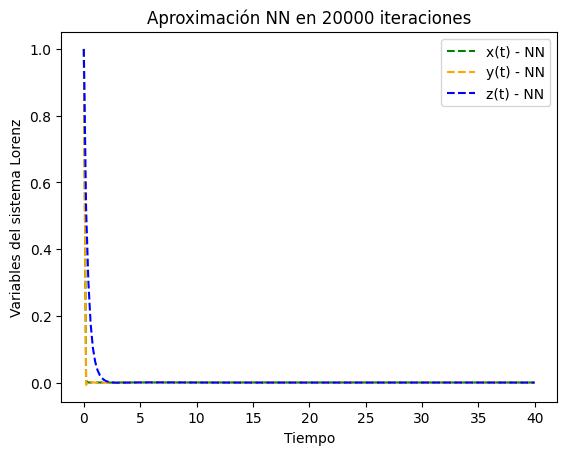

In [104]:
plt.figure()

plt.plot(t.cpu(), y[:,0].cpu(), linestyle='--', color="green", label="x(t) - NN")
plt.plot(t.cpu(), y[:,1].cpu(), linestyle='--', color="orange", label="y(t) - NN")
plt.plot(t.cpu(), y[:,2].cpu(), linestyle='--', color="blue", label="z(t) - NN")

plt.legend()
plt.title(f'Aproximación NN en {num_epoch} iteraciones')
plt.xlabel("Tiempo")
plt.ylabel("Variables del sistema Lorenz")
plt.show()

#### Gráfica 2D (COMPARACIÓN)

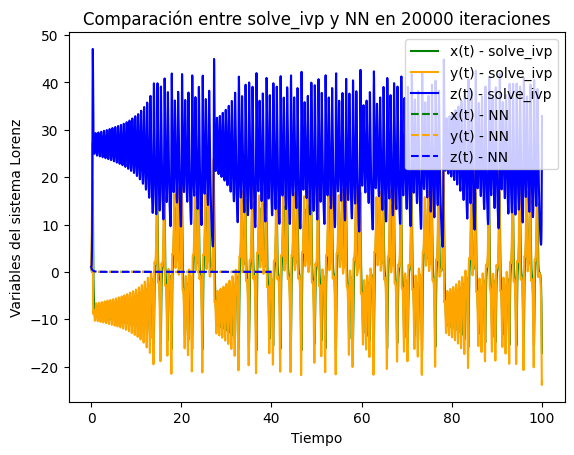

In [105]:
plt.figure()
plt.plot(sol.t, sol.y[0], color='green', label="x(t) - solve_ivp")
plt.plot(sol.t, sol.y[1], color='orange', label="y(t) - solve_ivp")
plt.plot(sol.t, sol.y[2], color='blue', label="z(t) - solve_ivp")

plt.plot(t.cpu(), y[:,0].cpu(), linestyle='--', color="green", label="x(t) - NN")
plt.plot(t.cpu(), y[:,1].cpu(), linestyle='--', color="orange", label="y(t) - NN")
plt.plot(t.cpu(), y[:,2].cpu(), linestyle='--', color="blue", label="z(t) - NN")

plt.legend()
plt.title(f'Comparación entre solve_ivp y NN en {num_epoch} iteraciones')
plt.xlabel("Tiempo")
plt.ylabel("Variables del sistema Lorenz")
plt.show()

###- ERROR de ENTRENAMIENTO y EVOLUCIÓN del LEARNING RATE

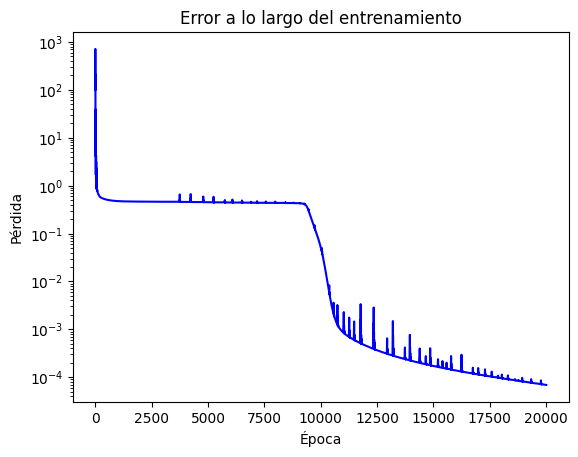

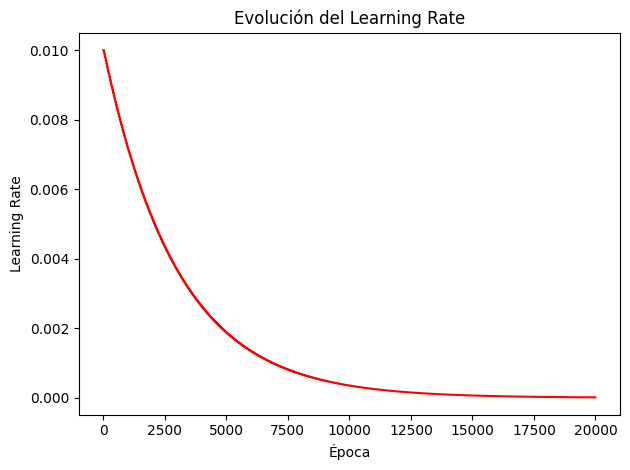

In [106]:
# Crear una figura con dos subgráficas
plt.figure(1)
# Graficar la evolución de la pérdida
plt.plot(range(1, len(loss_history) + 1), loss_history, label='Training Loss', color='blue')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Error a lo largo del entrenamiento')
plt.yscale('log')            # escala logarítmica se utiliza generalmente cuando los valores de la pérdida varían en un rango amplio

plt.figure(2)
# Graficar la evolución del learning rate
plt.plot(range(1, len(loss_history) + 1), learning_rates, label='Learning Rate', color='red')
plt.xlabel('Época')
plt.ylabel('Learning Rate')
plt.title('Evolución del Learning Rate')


# Ajustar el diseño y mostrar la gráfica
plt.tight_layout()
plt.show()